# Sentiment Analysis

Opinion mining (sometimes known as sentiment analysis or emotion AI) refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. [wikipedia]

We can use natural language processing, statistics and text analysis to extract, identify the given sentiment of a text and classify them as positive, negative and neutral.

## Sentiment analysis use cases

  - Customer service: Prioritizing customers based on email, tweets
  - Brand Monitoring: Analyse reviews on different products
  - Politics: Forecasting public sentiment towards social issues

## Sentiment analysis pipeline
Analysis of a given text can be broken down into following steps:-

1. Data acquisition: We can acquire data from multiple channels for the analysis. The channels comprise of social platforms e.g. Facebook, Twitter and internal customer service platforms.
2. Pre-processing: The next step involves pre processing the text. This step involved cleansing and standardization of text. We get rid of any redundant/uninformative text.
3. Classification: This step involves classification of cleansed text into different classes. A basic classification involves determining the polarity of a given text. Polarity score can range from -1 to -1, -1 being negative sentence while +1 being a positive sentence. A different classification involves finding the subjectivity/objectivity of a given text.

<img src="https://i.imgur.com/OxrKNeP.png" alt="Sentiment analysis" title="Sentiment analysis pipeline" style="width: 300px"/>

[wikipedia]: <https://en.wikipedia.org/wiki/Sentiment_analysis>

## Tutorial Content
We will perform sentiment analysis on Twitter data of four most frequently used airline in United States, namely, United Airlines, Southwest Airline, Delta Airways and American Airline.

In this tutorial we cover data acquisition via [Twitter API](https://developer.twitter.com/), cleaning and analysis of airline data.

### Libraries
1. [TextBlob](http://textblob.readthedocs.io/en/dev/quickstart.html): A simplified text processing library. We use it to find the polarity of a given text.
2. [NLTK](https://www.nltk.org/): A natural language toolkit for python.
3. [tweet-preprocessor](https://pypi.python.org/pypi/tweet-preprocessor/0.4.0): Library to clean, parse and tokenize twitter data.
4. [tweepy](http://www.tweepy.org/): Python library for accessing twitter data.

In [2]:
import sys
import pandas as pd
import preprocessor as tweetprocessor
import nltk
import string
import unicodedata
import ast
import tweepy
import csv
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 200

from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
from textblob import TextBlob
from matplotlib import figure
from wordcloud import WordCloud

pd.options.display.max_colwidth = 200

## Twitter data acquisition
We will use Twitter API to collect the tweets about four major airlines. We first need to register an application on Twitter and get API keys. We will use these API Keys to query the Twitter API.

Register Twitter App:-
1. Go to [https://apps.twitter.com/](https://apps.twitter.com/) and create a new app.
2. Generate Access Token and Access Token Secret.

We need four keys to query the Twitter API
- Consumer Key (API Key)
- Consumer Secret (API Secret)
- Access Token
- Access Token Secret

We use Tweepy to query the Twitter API and collect 5 days of tweets for every airline using their respective hashtags. 
Airline and their respective hashtags
1. American Airline = #AmericanAirline
2. Delta = #DeltaAirline
3. United Airline = #UnitedAirline
4. Southwest Airline = #SouthwestAirline

We save the data of format "Data_Created, Text" in a CSV file.

In [3]:
consumer_key = '************'
consumer_secret = '************'

access_token = '************'
access_token_secret = '************'


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth,wait_on_rate_limit=True)

csvFile = open('delta.csv', 'w+')
csvWriter = csv.writer(csvFile)

for tweet in tweepy.Cursor(api.search,q="#DeltaAirlines", lang="en", since="2018-03-25").items():
    print (tweet.created_at, tweet.text)
    csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8')])

csvFile = open('united.csv', 'w+')
csvWriter = csv.writer(csvFile)

for tweet in tweepy.Cursor(api.search, q="#UnitedAirlines", lang="en", since="2018-03-25").items():
    print(tweet.created_at, tweet.text)
    csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8')])

csvFile = open('american.csv', 'w+')
csvWriter = csv.writer(csvFile)

for tweet in tweepy.Cursor(api.search, q="#AmericanAirlines", lang="en", since="2018-03-25").items():
    print(tweet.created_at, tweet.text)
    csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8')])

csvFile = open('southwest.csv', 'w+')
csvWriter = csv.writer(csvFile)

for tweet in tweepy.Cursor(api.search, q="#SouthwestAirlines", lang="en", since="2018-03-25").items():
    print(tweet.created_at, tweet.text)
    csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8')])

## Loading the data
In the previous section we stored the airline data in their respective csv files. We load the CSV file as pandas dataframe.

NOTE: The csv files do not contain header row. Thus, we need to define our own header row for the dataframe. As, the tweet text returned by the Twitter API is in the form of Bytes or String. We use 'ast.literal_eval' to load the data to the dataframe in the original format.

In [4]:
cols = ['timestamp', 'tweet']

united = pd.read_csv('./united.csv', parse_dates=[0], header=None, names=cols)
american = pd.read_csv('./american.csv', parse_dates=[0], header=None, names=cols)
southwest = pd.read_csv('./southwest.csv', parse_dates=[0], header=None, names=cols)
delta = pd.read_csv('./delta.csv', parse_dates=[0], header=None, names=cols)

united['tweet'] = united['tweet'].apply(ast.literal_eval)
american['tweet'] = american['tweet'].apply(ast.literal_eval)
southwest['tweet'] = southwest['tweet'].apply(ast.literal_eval)
delta['tweet'] = delta['tweet'].apply(ast.literal_eval)

## Pandas Dataframe
The following cells provide an insight into the data collected via the Twitter API for 4 different airlines. We can observe that, the tweet text are not standardized in the terms of encoding and contains urls text and hashtags.

In [5]:
united.head()

,timestamp,tweet
0,2018-03-30 19:34:46,b'#UnitedAirlines #ewr ... honestly. No sandwiches bought outside your pop-up lounge can be eaten inside ? At the sam\xe2\x80\xa6 https://t.co/dCRiZQtXWV'
1,2018-03-30 18:55:31,b'This is the first time and last time I fly #UnitedAirlines! My flight was at 10:40 am this morning and we are still\xe2\x80\xa6 https://t.co/oK2j0MZzt0'
2,2018-03-30 18:36:05,"b'Toronto, Canada to Hawaii for only $542 CAD roundtrip with United Airlines. #UnitedAirlines #Toronto https://t.co/EMHwq5ZNxQ'"
3,2018-03-30 18:36:04,"b'Toronto, Canada to Hawaii for only $542 CAD roundtrip with United Airlines. #UnitedAirlines #Toronto https://t.co/P099e8pbpQ'"
4,2018-03-30 18:30:59,b'3 hour flight no WiFi and three screaming babies ... bruh #UnitedAirlines'


In [6]:
american.head()

,timestamp,tweet
0,2018-03-30 20:10:17,"b'Hey @AmericanAir, you and your travel partners have made what was supposed to be a great trip miserable going (2 da\xe2\x80\xa6 https://t.co/9QGUV88ZKK'"
1,2018-03-30 20:08:37,"b'@AmericanAir Gate agents left our student group in JFK last night without any help, now our flight is delayed again\xe2\x80\xa6 https://t.co/HYKoA4Cu5u'"
2,2018-03-30 19:28:42,b'Rough travel day with #AmericanAirlines out of AUS. Ticket agent Jason Davis is a total jerk and our on board fligh\xe2\x80\xa6 https://t.co/CraHCyibaB'
3,2018-03-30 19:10:20,b'#AmericanAirlines now crew timed out!! Fun day.'
4,2018-03-30 19:07:13,"b'With direct flights to MTJ, there are no excuses! Come see us soon! https://t.co/qDBedNK7lM\n.\n.\n.\n#hoteltelluride\xe2\x80\xa6 https://t.co/ouoZ6eRKwY'"


In [7]:
southwest.head()

,timestamp,tweet
0,2018-03-30 19:34:36,b'Are you an OAK Ron #Check #Mechanic in #Oakland? #SouthwestAirlines is waiting for you! #job https://t.co/tKhUgOTRNS https://t.co/tK2MjAFjmK'
1,2018-03-30 19:23:43,"b'#SouthwestAirlines is looking for a Senior #Analyst #Business Performance, apply now! (#Dallas) #job\xe2\x80\xa6 https://t.co/V4zV62AFrD'"
2,2018-03-30 19:17:05,"b'#SouthwestAirlines is looking for a Sr #Analyst in #Dallas, apply now! #job https://t.co/dobNV2ob7j https://t.co/AqusuXB8Ub'"
3,2018-03-30 19:01:50,b'Check out this #job: Ramp #Agent at #SouthwestAirlines (#Nashville) https://t.co/7zvIevp9NR https://t.co/1hB7plTtZ2'
4,2018-03-30 18:52:58,b'Had bummer flight attendants this a.m. on #SouthwestAirlines 1920 from MCO to BWI. SWA is always friendly and fun.\xe2\x80\xa6 https://t.co/gL3nUE4wig'


In [8]:
delta.head()

,timestamp,tweet
0,2018-03-30 19:57:58,"b'So proud of our Aviation Maintenance Technology Program @PortlandCC for signing pact with #deltaairlines , Rock Cre\xe2\x80\xa6 https://t.co/SZD18yV1hs'"
1,2018-03-30 19:21:49,b'RT @GaiChicken: This evening\xe2\x80\x99s sunset over @LASairport &amp; the #LasVegasStrip\n\n#LasVegas #LAS #Sunset #Airport #Delta #DeltaAirlines #Runway\xe2\x80\xa6'
2,2018-03-30 18:52:02,"b'@CNNPolitics Those companies cowering to this baby fascist,who cant take the truth, are going to feel the same PAIN\xe2\x80\xa6 https://t.co/xFGhdQfHmW'"
3,2018-03-30 18:04:09,"b'RT @ClintEastwoodLA: ""The word #Delta means \'Change\'. \n\nI will be changing Airline\'s, @Delta. \n\nIf you hate the #NRA so much maybe you shou\xe2\x80\xa6'"
4,2018-03-30 17:58:39,b'RT @GaiChicken: This evening\xe2\x80\x99s sunset over @LASairport &amp; the #LasVegasStrip\n\n#LasVegas #LAS #Sunset #Airport #Delta #DeltaAirlines #Runway\xe2\x80\xa6'


## Text Cleansing and Standardization

The tweet text are not standardized and we need to perform operations to clean twitter data. We perform following operations to clean the text.

1. Decode: Some of the tweets returned by Twitter API are in Byte format. We need to decode them to convert back to string.
2. Remove hastags and Urls: We remove hastags and urls from the tweet text as they do not provide meaningful information for sentiment analysis.
3. Remove unicode chracters: We remove the unicode characters as we are considering only ascii for our analysis.
4. Tokenization: We use NLTK RegexpTokenizer for tokenization. Regex (r'w+') only keeps the english letters in our text.
5. Lemmatization: We use NLTK's WordNetLemmatizer to lemmatize tokens in our text.

In the below section we have used tweet-preprocessor python library to clean the text. This library removes hastags, urls and twitter mentions from the text.

In [9]:
def clean_tweets(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer(), tokenizer = RegexpTokenizer(r'\w+')):
    if type(text) == str:
        text = text[1:-1]
        text = text.encode()

    text = text.decode()
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text()
    text = tweetprocessor.clean(text)
    text = text.lower()
    tbl = dict.fromkeys(i for i in range(sys.maxunicode) if unicodedata.category(chr(i)).startswith('P'))
    text = text.translate(tbl)

    tokens = tokenizer.tokenize(text)
    lemmatized_list = []
    for token in tokens:
        try:
            lemmatized = lemmatizer.lemmatize(token)
            lemmatized_list.append(lemmatized)
        except:
            continue
    tokens = [str(token) for token in lemmatized_list]
    cleaned_tweet = ' '.join(tokens)
    return cleaned_tweet

In [10]:
united['tweet'] = united['tweet'].apply(lambda txt: clean_tweets(txt))
american['tweet'] = american['tweet'].apply(lambda txt: clean_tweets(txt))
southwest['tweet'] = southwest['tweet'].apply(lambda txt: clean_tweets(txt))
delta['tweet'] = delta['tweet'].apply(lambda txt: clean_tweets(txt))

## Polarity
Polarity is one of the text classification techniques for sentiment analysis. It is the calculation of emotion expressed in a sentence. We use polarity as a measure to analyze the tweet text and find insights about the major airlines.

It takes into account the number of positive or negative terms in a dataset. Polarity, classifies a text in positive, neutral or negative classes. 

We use python library TextBlob to calculate the polarity of a tweet. TextBlob internally uses NaiveBayes Classifier for polarity calculations. For any given text, TextBlob returns a polarity value between -1 to 1. -1 refers to negative polarity and 1 referes to positive polarity. A polarity value of 0 is classified as neutral.

In [11]:
def find_polarity(text):
    polarity = TextBlob(text).sentiment.polarity
    round_value = round(polarity, 4)
    return round_value

In [12]:
united['polarity'] = united['tweet'].apply(lambda txt: find_polarity(txt))
american['polarity'] = american['tweet'].apply(lambda txt: find_polarity(txt))
southwest['polarity'] = southwest['tweet'].apply(lambda txt: find_polarity(txt))
delta['polarity'] = delta['tweet'].apply(lambda txt: find_polarity(txt))

## Analysis 1
We have a polarity value for every tweet in our dataset. We now perform some analysis and visualization to gather more insights about airline tweets.

We first perform a time series analysis of polarity for every airline. This provides an insight into the positive and negative sentiments for a given airline over a period.

This can be an interesting trend to analyse, especially when an airline gets into a controversy.

[Text(0,0.5,'Polarity'), Text(0.5,0,'Date')]

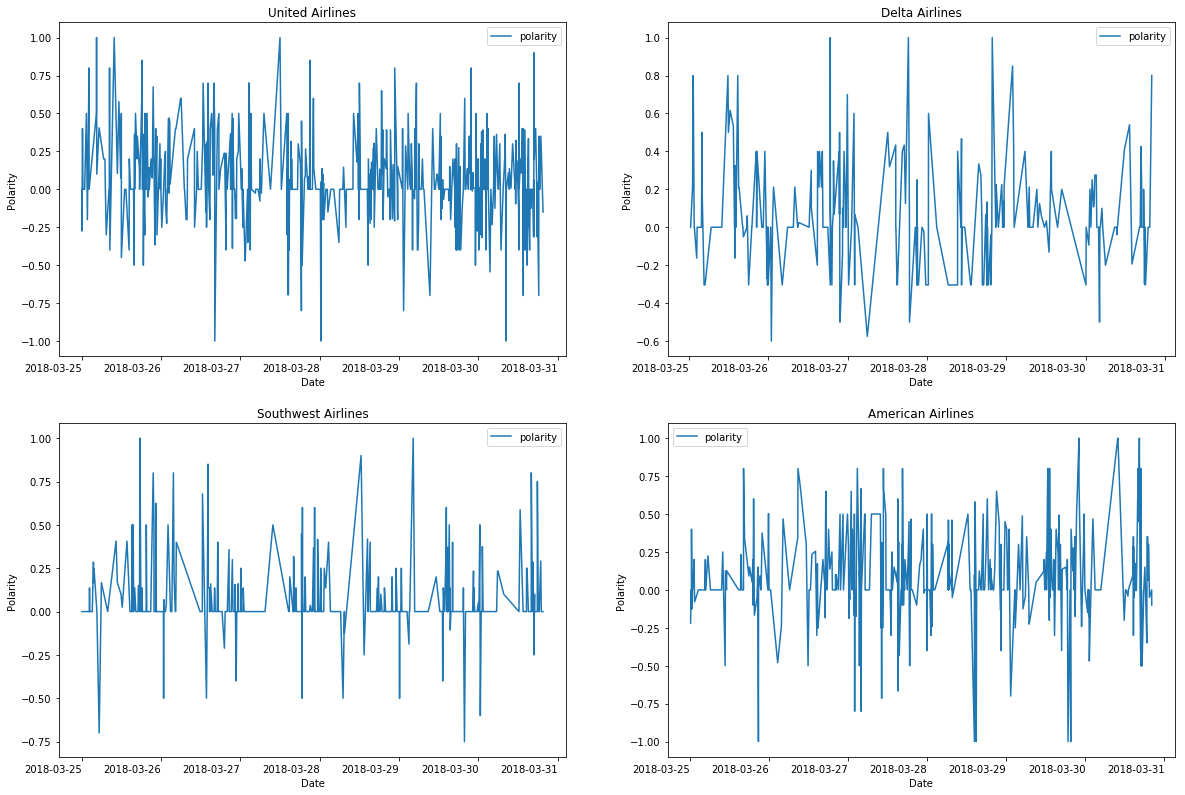

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(20)
fig.set_figheight(15)
plt1 = united.plot(x='timestamp', y='polarity', ax=axes[0,0], title='United Airlines', rot=0)
plt1.set(xlabel='Date', ylabel='Polarity')
plt2 = delta.plot(x='timestamp', y='polarity', ax=axes[0,1], title='Delta Airlines', rot=0)
plt2.set(xlabel='Date', ylabel='Polarity')
plt3 = southwest.plot(x='timestamp', y='polarity', ax=axes[1,0], title='Southwest Airlines', rot=0)
plt3.set(xlabel='Date', ylabel='Polarity')
plt4 = american.plot(x='timestamp', y='polarity', ax=axes[1,1], title='American Airlines', rot=0)
plt4.set(xlabel='Date', ylabel='Polarity')

## Analysis 2
We will now find the sentiment of passengers for every airline. We plot the positive and negative sentiment for the airline against the number of tweets.

This provides an insight into the customer satisfaction for a given airline.

[Text(0,0.5,'No. of Tweets'),
 Text(0.5,0,'Airline'),
 Text(0.5,1,'Airline Sentiment')]

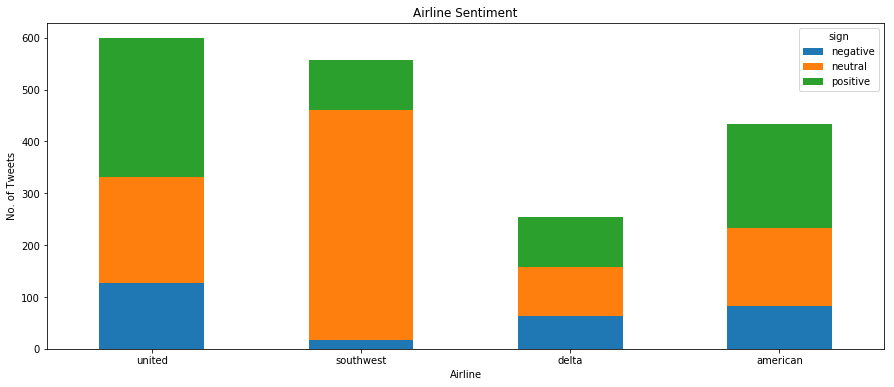

In [14]:
united['sign'] = np.sign(united['polarity']).map({1:'positive', -1:'negative', 0:'neutral'})
southwest['sign'] = np.sign(southwest['polarity']).map({1:'positive', -1:'negative', 0:'neutral'})
delta['sign'] = np.sign(delta['polarity']).map({1:'positive', -1:'negative', 0:'neutral'})
american['sign'] = np.sign(american['polarity']).map({1:'positive', -1:'negative', 0:'neutral'})

df1 = pd.DataFrame(united.groupby(['sign'])['sign'].count()).transpose().reset_index().rename(index={0: 'united'})
df2 = pd.DataFrame(southwest.groupby(['sign'])['sign'].count()).transpose().reset_index().rename(index={0: 'southwest'})
df3 = pd.DataFrame(delta.groupby(['sign'])['sign'].count()).transpose().reset_index().rename(index={0: 'delta'})
df4 = pd.DataFrame(american.groupby(['sign'])['sign'].count()).transpose().reset_index().rename(index={0: 'american'})

df_all = pd.concat([df1, df2, df3, df4])
fig = df_all.plot.bar(stacked=True, figsize=(15, 6), rot=0)
fig.set(xlabel='Airline', ylabel='No. of Tweets', title='Airline Sentiment')

## Analysis 3
We can observe that in the above graph though we get an insight into each airline, its difficult to compare airlines as the number of tweets fetched are different.

In the following analysis, we normalize the the polarity of tweets such that the positive, negative and neutral tweets are a percentage.

Normalization provides us better insight about customer sentiment and allows us to comapre one airline to another.

[Text(0,0.5,'Percentage of Tweets'),
 Text(0.5,0,'Airline'),
 Text(0.5,1,'Airline Sentiment Normalized')]

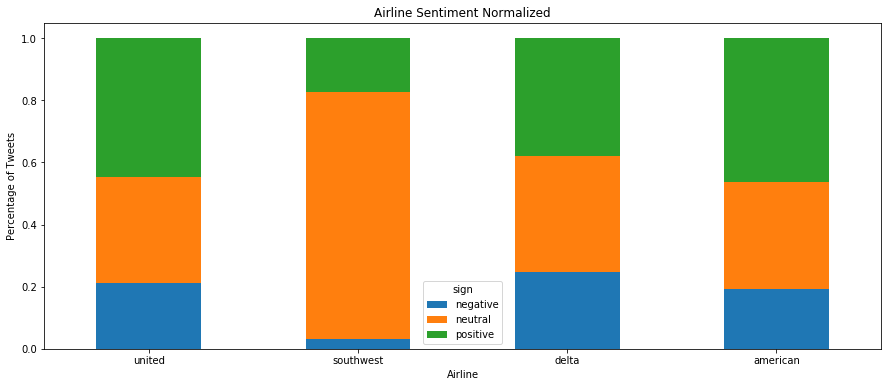

In [15]:
df_all.head()
df_normalized = df_all.copy(deep=True).drop(['index'], axis=1)
df_normalized = df_normalized.apply(lambda x: x/x.sum(), axis=1)
fig = df_normalized.plot.bar(stacked=True, figsize=(15, 6), rot=0)
fig.set(xlabel='Airline', ylabel='Percentage of Tweets', title='Airline Sentiment Normalized')

## Analysis 4
Lastly, we try to find what exactly the customers are talking about respective airline. We can plot a wordcloud of all the text for a airline.

We can observe the most frequent sentiment expressed by customers in the tweets.

Text(0.5,1,'American Airlines')

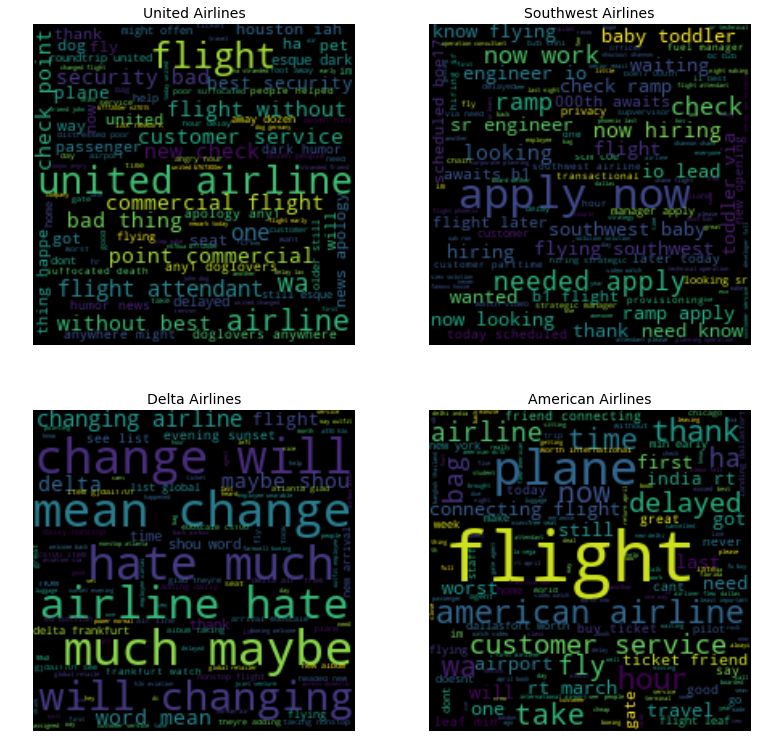

In [23]:
united_text = ' '.join(united['tweet'])
soutwest_text = ' '.join(southwest['tweet'])
delta_text = ' '.join(delta['tweet'])
american_text = ' '.join(american['tweet'])

wordcloud_u = WordCloud(width=200, height=200, margin=0).generate(united_text)
wordcloud_s = WordCloud(width=200, height=200, margin=0).generate(soutwest_text)
wordcloud_d = WordCloud(width=200, height=200, margin=0).generate(delta_text)
wordcloud_a = WordCloud(width=200, height=200, margin=0).generate(american_text)

fig = plt.figure(figsize=(13, 13))
ax1 = fig.add_subplot(2,2,1) 
ax1.imshow(wordcloud_u, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('United Airlines', fontsize=14)

ax2 = fig.add_subplot(2,2,2) 
ax2.imshow(wordcloud_s, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Southwest Airlines', fontsize=14)

ax2 = fig.add_subplot(2,2,3) 
ax2.imshow(wordcloud_d, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Delta Airlines', fontsize=14)

ax2 = fig.add_subplot(2,2,4) 
ax2.imshow(wordcloud_a, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('American Airlines', fontsize=14)

## Further Resources
1. https://nlp.stanford.edu/sentiment/
2. https://cloud.google.com/natural-language/docs/sentiment-tutorial

## References
1. http://ipullrank.com/step-step-twitter-sentiment-analysis-visualizing-united-airlines-pr-crisis/
2. https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90
3. http://blog.aylien.com/build-a-sentiment-analysis-tool-for-twitter-with-this-simple-python-script/
4. https://towardsdatascience.com/five-practical-use-cases-of-customer-sentiment-analysis-for-nps-a3167ac2caaa
5. https://blog.algorithmia.com/introduction-sentiment-analysis/